## Setup

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


## Data manipulation

In [10]:
import pathlib

data_dir = pathlib.Path("./data/")
train_dir = pathlib.Path("./data/train/")
test_dir = pathlib.Path("./data/test/")
valid_dir = pathlib.Path("./data/valid/")

training_image_count = len(list(data_dir.glob('train/*/*.jpg')))
test_image_count = len(list(data_dir.glob('test/*/*.jpg')))
validation_image_count = len(list(data_dir.glob('valid/*/*.jpg')))
total_count = training_image_count + test_image_count + validation_image_count

print(f"training_image_count: {training_image_count}")
print(f"test_image_count: {test_image_count}")
print(f"validation_image_count: {validation_image_count}")
print(f"total_count: {total_count}")


training_image_count: 84635
test_image_count: 2625
validation_image_count: 2625
total_count: 89885


#### Creating keras dataset

In [11]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(class_names)



Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'ASIAN GREEN BEE EATER', 'ASIAN OPENBILL STORK', 'AUCKLAND SHAQ', 'AUSTRAL CANASTERO', 'AUSTRALASIAN FIGBIRD', 

#### Visualizing some birds

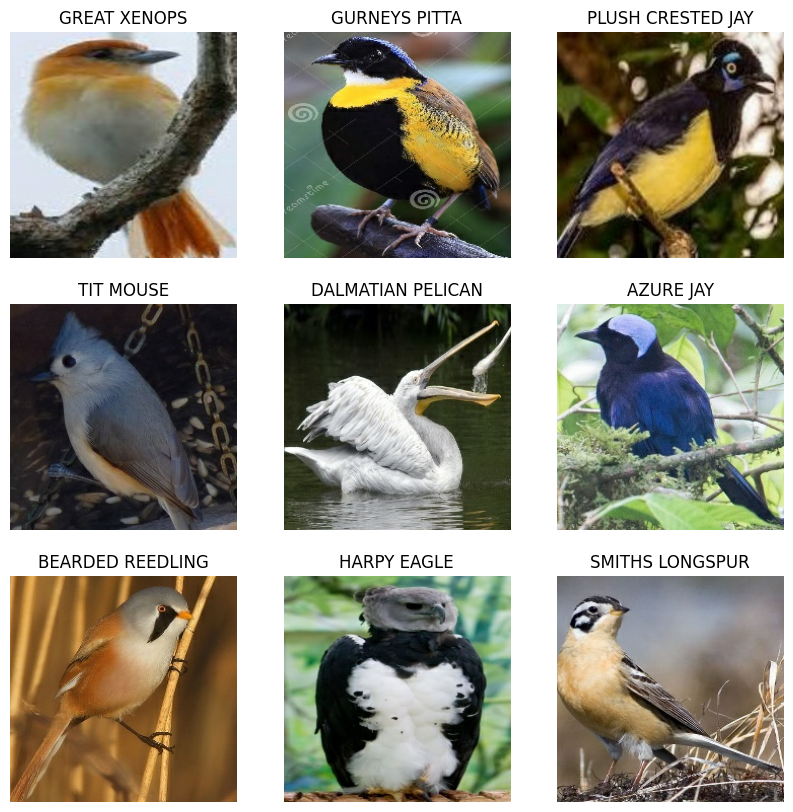

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


#### Configure dataset performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


#### Standardize the data

In [14]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 1.0


### Data Augumentation

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


#### Visualize augumentation

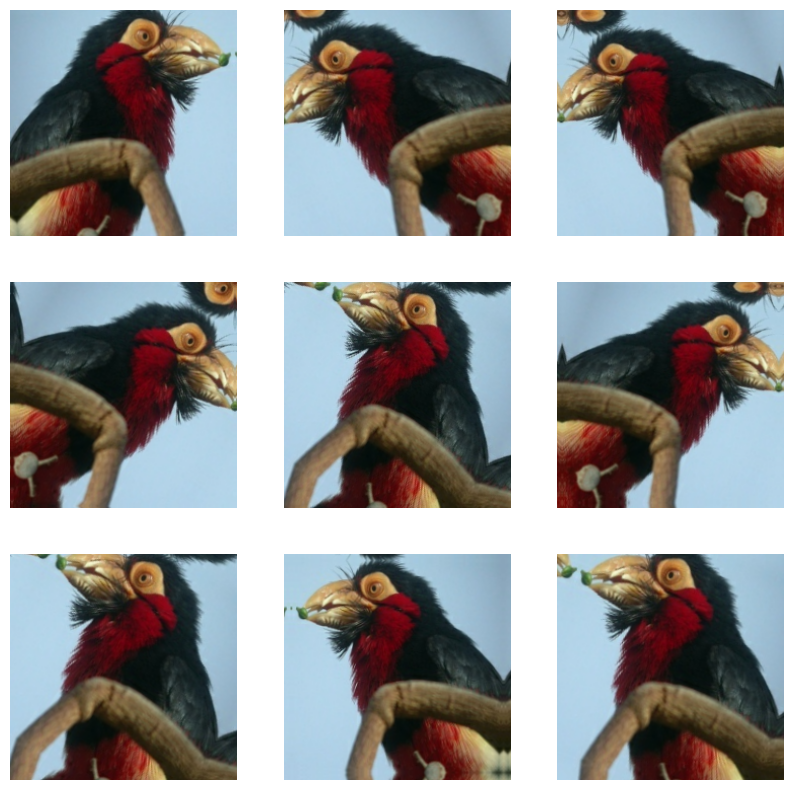

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


## Model

In [21]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


#### Compile model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#### Model summary

In [24]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)       

#### Train model

In [25]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
2645/2645 [==============================] - 588s 222ms/step - loss: 4.9706 - accuracy: 0.0837 - val_loss: 3.8624 - val_accuracy: 0.2198
Epoch 2/15
2645/2645 [==============================] - 591s 224ms/step - loss: 3.5385 - accuracy: 0.2552 - val_loss: 2.9431 - val_accuracy: 0.3672
Epoch 3/15
2645/2645 [==============================] - 592s 224ms/step - loss: 2.9888 - accuracy: 0.3460 - val_loss: 2.5503 - val_accuracy: 0.4419
Epoch 4/15
2645/2645 [==============================] - 592s 224ms/step - loss: 2.7233 - accuracy: 0.3952 - val_loss: 2.4166 - val_accuracy: 0.4754
Epoch 5/15
2645/2645 [==============================] - 595s 225ms/step - loss: 2.5584 - accuracy: 0.4263 - val_loss: 2.3203 - val_accuracy: 0.4990
Epoch 6/15
2645/2645 [==============================] - 599s 226ms/step - loss: 2.4188 - accuracy: 0.4525 - val_loss: 2.3116 - val_accuracy: 0.5044
Epoch 7/15
2645/2645 [==============================] - 597s 226ms/step - loss: 2.3362 - accuracy: 0.4675 - val_

#### Training results

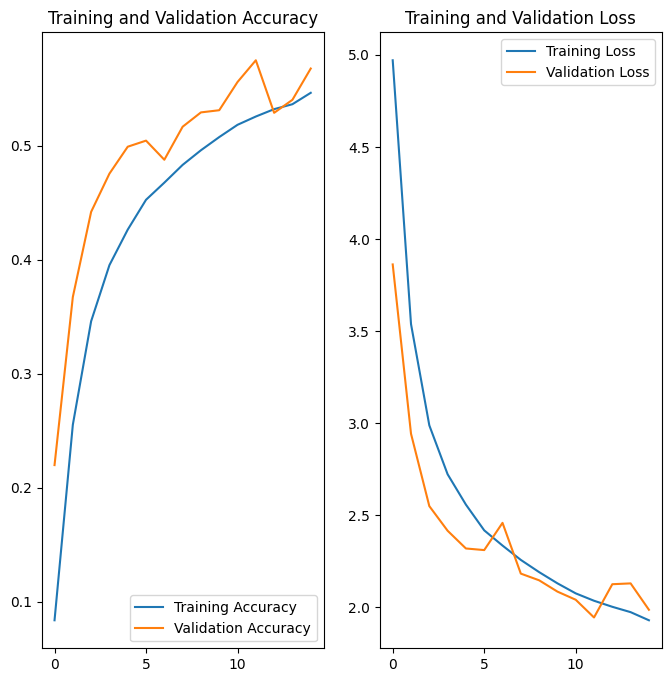

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Prediction

In [50]:
test_image_list =list(data_dir.glob('test/*/*.jpg'))
image = test_image_list[11] # Set another index
print(str(image).split("/")[2])

img = tf.keras.utils.load_img(image, target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


FRIGATE
This image most likely belongs to FRIGATE with a 75.68 percent confidence.


#### Model export

In [56]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpbh5jcgtw/assets


INFO:tensorflow:Assets written to: /tmp/tmpbh5jcgtw/assets
